<a href="https://colab.research.google.com/github/AbdullahAZaidi/Stereo_Calibration/blob/main/Stereo_Factory_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from io import StringIO
from pathlib import Path
import sys
from typing import NamedTuple, Any
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import h5py
import glob
import numpy as np
import cv2
import os

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_excel('/content/gdrive/Shareddrives/External_Primax/Sample_Calibration_Data_Abdullah/P10_Intrinsic_calibration.xlsx')

def load_camera_matrix(Camera):
  Fx = df[Camera].values[0]
  Fy = df[Camera].values[1]
  Cx = df[Camera].values[2]
  Cy = df[Camera].values[3]
  
  return np.array([[ Fx,  0.,  Cx ],
                  [ 0.,  Fy,  Cy ],
                  [ 0.,  0.,  1 ]])


def load_dist_coeff(Camera):
    K1 = df[Camera].values[4]
    K2 = df[Camera].values[5]
    P1 = df[Camera].values[6]
    P2 = df[Camera].values[7]
    K3 = df[Camera].values[8]

    return np.array ([K1, K2, P1, P2, K3])


def _find_checkerboard_corners(tgt_size, imfile_path: Path) -> Any:
    print(f'Loading {imfile_path} ...', file=sys.stderr)
    assert imfile_path.is_file(), f"{imfile_path} is not a valid file"
    im = cv2.imread(str(imfile_path))
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#     plt.imshow(im)

    print('  finding chessboard corners ...', file=sys.stderr)
    pattern_was_found, pixel_corners = cv2.findChessboardCorners(gray_im, tgt_size, flags=cv2.CALIB_CB_FAST_CHECK)
    assert pattern_was_found, f"No corners detected!"
#     cv2.cornerSubPix(gray_im, pixel_corners, (11, 11), (-1, 1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    if (pixel_corners[0] > pixel_corners[-1]).all():
        print(f'Flipping reversed checkboard detections for {imfile_path}', file=sys.stderr)
        pixel_corners = pixel_corners[::-1]  # Corners must be top-bottom

    print('  writing corner detection visualization ...', file=sys.stderr)
    cv2.drawChessboardCorners(im, tgt_size, pixel_corners, pattern_was_found)
    cv2.imwrite(f"plots/{imfile_path.name}", im)

    return pixel_corners, gray_im.shape[::-1]

def _find_checkerboard_corners2(tgt_size, imfile_path: Path) -> Any:
    print(f'Loading {imfile_path} ...', file=sys.stderr)
    assert imfile_path.is_file(), f"{imfile_path} is not a valid file"
    im = cv2.imread(str(imfile_path))
    im = im[0:im.shape[0]*5//9, 0:im.shape[1]]
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(im)

    print('  finding chessboard corners ...', file=sys.stderr)
    pattern_was_found, pixel_corners = cv2.findChessboardCorners(gray_im, tgt_size, flags=cv2.CALIB_CB_FAST_CHECK)
    assert pattern_was_found, f"No corners detected!"
    cv2.cornerSubPix(gray_im, pixel_corners, (11, 11), (-1, 1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    if (pixel_corners[0] > pixel_corners[-1]).all():
        print(f'Flipping reversed checkboard detections for {imfile_path}', file=sys.stderr)
        pixel_corners = pixel_corners[::-1]  # Corners must be top-bottom

    print('  writing corner detection visualization ...', file=sys.stderr)
    cv2.drawChessboardCorners(im, tgt_size, pixel_corners, pattern_was_found)
    cv2.imwrite(f"plots/{imfile_path.name}", im)

    return pixel_corners, gray_im.shape[::-1]


def _load_correspondences_impl(tgt_size, img_file_paths, patch_size: float=25):
    known_target_points = np.zeros((tgt_size[0] * tgt_size[1], 3), np.float32)
    known_target_points[:,:2] = np.mgrid[0:tgt_size[0], 0:tgt_size[1]].T.reshape(-1,2) * patch_size

    correspondences = {}
    for file_path in img_file_paths:
        pixel_corners, im_dimensions = _find_checkerboard_corners(tgt_size, file_path)
        correspondences[file_path] = (known_target_points, pixel_corners, im_dimensions)
    return correspondences

def _load_correspondences_impl2(tgt_size, img_file_paths, patch_size: float=10):
    known_target_points = np.zeros((tgt_size[0] * tgt_size[1], 3), np.float32)
    known_target_points[:,:2] = np.mgrid[0:tgt_size[0], 0:tgt_size[1]].T.reshape(-1,2) * patch_size

    correspondences = {}
    for file_path in img_file_paths:
        pixel_corners, im_dimensions = _find_checkerboard_corners(tgt_size, file_path)
        correspondences[file_path] = (known_target_points, pixel_corners, im_dimensions)
    return correspondences

def load_correspondences_checkerboard(img_file_paths):
    return _load_correspondences_impl((19, 13), img_file_paths)


def load_correspondences_cross_chart(img_file_paths):
    return _load_correspondences_impl2((14, 7), img_file_paths)


def angle_axis_to_matrix(angle_axis: np.ndarray) -> np.ndarray:
    """ Convert a rotation from an angle-axis representation to its
    matrix representation.

    Params
    ------
    `angle_axis`: numpy.ndarray with shape (3,)
        This vector represents a rotation about an axis. Its magnitude
        represents the angle of rotation, in radians, and its (unit-)
        direction represents the axis of rotation. Hence a rotation of
        π/4 about the z-axis would be represented as:
        `np.array([0, 0, np.pi/4])`.

    Returns
    -------
    A unitary, orthonormal, 4x4 transformation matrix that represents the
    same rotation as `angle_axis`.
    """
    magnitude = np.linalg.norm(angle_axis)
    angle, x, y, z = magnitude, *(angle_axis / magnitude)
    K = np.array([ 0, -z,  y,
                   z,  0, -x,
                  -y,  x,  0 ]).reshape(3, 3)
    # Compute exponential map (exp(K)) using Rodriguez's formula
    R = np.eye(3) + (np.sin(angle) * K) + ((1 - np.cos(angle)) * (K @ K))

    matrix_4x4 = np.eye(4)
    matrix_4x4[:3, :3] = R
    return matrix_4x4


def translation_matrix(x: float, y: float, z: float):
    """ Return a 4x4 matrix representating the (x, y, z) translation
    """
    return np.array([[ 1.,  0.,  0.,  x  ],
                     [ 0.,  1.,  0.,  y  ],
                     [ 0.,  0.,  1.,  z  ],
                     [ 0.,  0.,  0.,  1. ]])


def rtvec_to_matrix(rvec, tvec) -> np.ndarray:
    return translation_matrix(*tvec) @ angle_axis_to_matrix(rvec)


def matrix_to_xyzrph(M: np.ndarray):
    tx = M[0, 3]
    ty = M[1, 3]
    tz = M[2, 3]
    rx = np.arctan2(M[2, 1],  M[2, 2])
    ry = np.arctan2(-M[2, 0],  np.sqrt(M[0, 0]*M[0, 0] + M[1, 0]*M[1, 0]))
    rz = np.arctan2(M[1, 0],  M[0, 0])
    return tx, ty, tz, rx, ry, rz

class CameraCalibrationResult(NamedTuple):
    rms_reprojection_err: Any
    cam_mat: Any
    dist_coeffs: Any
    cam_from_target_poses: Any


def calibrate_camera(correspondences):
    obj_points = [ o for o, _i, _s in correspondences.values() ]
    img_points = [ i for _o, i, _s in correspondences.values() ]
    im_shapes = [ s for _o, _i, s in correspondences.values() ]
    assert all( im_shapes[0] == s for s in im_shapes )
    rmse, cam_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, im_shapes[0], None, None)
    cam_from_target_poses = [ rtvec_to_matrix(r.squeeze(), t.squeeze()) for r, t in zip(rvecs, tvecs) ]
    return CameraCalibrationResult(rmse, cam_matrix, dist_coeffs, cam_from_target_poses)


def main():
    
    # loading camera matrix
    left_cam_mat = load_camera_matrix('Camera 1')
    right_cam_mat = load_camera_matrix('Camera 2')

    #load distortion coefficients
    left_dist_coeff = load_dist_coeff('Camera 1')
    right_dist_coeff = load_dist_coeff('Camera 2')

    lobj_points, limg_points, _ = list(load_correspondences_cross_chart([ Path('/content/gdrive/Shareddrives/External_Primax/Sample_Calibration_Data_Abdullah/L_PAIR10_CROSS0007.raw.bmp') ]).values())[0]
    robj_points, rimg_points, _ = list(load_correspondences_cross_chart([ Path('/content/gdrive/Shareddrives/External_Primax/Sample_Calibration_Data_Abdullah/R_PAIR10_CROSS0007.raw.bmp') ]).values())[0]

    _, r, t = cv2.solvePnP(lobj_points, limg_points, left_cam_mat, left_dist_coeff)
    leftcam_from_chart = rtvec_to_matrix(r.squeeze(), t.squeeze())
    
    _, r, t = cv2.solvePnP(robj_points, rimg_points, right_cam_mat, right_dist_coeff)
    rightcam_from_chart = rtvec_to_matrix(r.squeeze(), t.squeeze())

    print('Relative camera positions: ',
          matrix_to_xyzrph(leftcam_from_chart @ np.linalg.inv(rightcam_from_chart)), file=sys.stderr)

if __name__ == '__main__':
    main()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading /content/gdrive/Shareddrives/External_Primax/Sample_Calibration_Data_Abdullah/L_PAIR10_CROSS0007.raw.bmp ...
  finding chessboard corners ...
  writing corner detection visualization ...
Loading /content/gdrive/Shareddrives/External_Primax/Sample_Calibration_Data_Abdullah/R_PAIR10_CROSS0007.raw.bmp ...
  finding chessboard corners ...
  writing corner detection visualization ...
Relative camera positions:  (396.4130928384445, -16.385892210189652, -2.370335944115368, -0.02437012765141098, -0.004078800261767037, -0.008336011462681512)


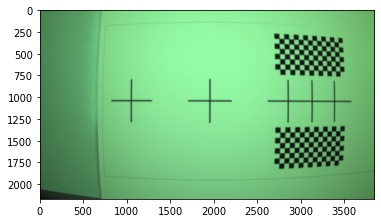

In [15]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

img = load_images_from_folder('/content/gdrive/Shareddrives/External_Primax/SSample_Calibration_Data_Abdullah/')
plt.imshow(img[0])